## Generating Synthetic Winds from Real Data

In [96]:
import h5py
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pytz

In [97]:
f = h5py.File('radial_wind_measurements_simone.h5', 'r') # Opening real wind data as a read only file

In [98]:
print(f.keys())

<KeysViewHDF5 ['alpha_norm', 'braggs', 'dh', 'dops', 'dt', 'heights', 'lats', 'lons', 'rgs', 't', 'times', 'v', 've']>


In [4]:
# Adding [:] at the end of each dataset to have it treated as an array 
noise = f['alpha_norm'][:]
braggs = f['braggs'][:] # 3-D Bragg vector 'k'
dops = f['dops'][:] # Doppler frequency shift 'f'
alts = f['heights'][:]
lats = f['lats'][:] # Degrees, km, seconds
lons = f['lons'][:] # Degrees, km, seconds
ts = f['t'][:]

In [5]:
print(np.max(np.sqrt(noise))) # The noise is the variation in the signal 

12.632247915163319


In [6]:
print(np.max(np.abs(dops)))

26.17501333333333


In [7]:
# Wind data taken over Germany
print(lats.min())
print(lats.max())
print(lons.min())
print(lons.max())
print(alts.min())
print(alts.max())

49.56209891232681
56.29294179234871
8.30760641435447
16.38683839092728
70.01937370315991
119.97548989474387


In [8]:
print(ts.min())
print(ts.max())

1541376005.0
1541462399.0


In [9]:
# This is converting the UTC time to local time here at Haystack (0 UTC is 19 EST)
print(datetime.fromtimestamp(1541376000.0).strftime("%A, %B %d, %Y %H:%M:%S"))
print(datetime.fromtimestamp(1541462400.0).strftime("%A, %B %d, %Y %H:%M:%S"))

Sunday, November 04, 2018 19:00:00
Monday, November 05, 2018 19:00:00


In [10]:
t0 = int(1541376000.0)

In [11]:
print(t0 + 24*60*60)

1541462400


In [12]:
with h5py.File('../simulated_winds_germany.h5', 'r') as winds: # Opening simulated wind data from Interpolation notebook as read only
    xsim = winds['x'][:] # Longitude (8-17)
    ysim = winds['y'][:] # Latitude (49-57)
    zsim = winds['z'][:] # Altitudes (82,84,86,88,90,92,94,96,98)
    u3dsim = winds['u3d'][:]
    v3dsim = winds['v3d'][:]

In [13]:
alt_window_idx = (alts >= 82) & (alts <= 98) # Pulling needed altitudes from real data to do synthetic interpolation

In [14]:
noise = noise[alt_window_idx]
braggs = braggs[alt_window_idx]
dops = dops[alt_window_idx]
alts = alts[alt_window_idx]
lats = lats[alt_window_idx]
lons = lons[alt_window_idx]
ts = ts[alt_window_idx]

In [15]:
# Importing simulated data created in Interpolation notebook
from scipy.interpolate import RegularGridInterpolator
uinterp = RegularGridInterpolator((xsim,ysim,zsim),u3dsim)
vinterp = RegularGridInterpolator((xsim,ysim,zsim),v3dsim)

In [16]:
# Creating new u and v values 
meas_locs = np.stack((lons, lats, alts), axis=-1)
u = uinterp(meas_locs)
v = vinterp(meas_locs)

In [17]:
noisy = np.random.normal(0,np.sqrt(noise),len(noise)) # Gaussian random noise

In [18]:
synthetic_doppler = (1 / (2*np.pi)) * (u*braggs[:,0] + v*braggs[:,1]) #This implements the Doppler measurement equation 2*pi*f = dot(k, u) when you "know" the Bragg vector and wind velocity.

In [19]:
noisy_synthetic_doppler = synthetic_doppler + noisy # adding Gaussian random noise to synthetic_doppler

In [20]:
with h5py.File('synthetic_data.h5', 'w') as f:
    f['noise'] = noise
    f['braggs'] = braggs
    f['dops'] = noisy_synthetic_doppler
    f['alts'] = alts
    f['lats'] = lats
    f['lons'] = lons
    f['t'] = ts
    f['u'] = u
    f['v'] = v
    f['synthetic_doppler'] = synthetic_doppler

In [21]:
# (let t0 be a timestamp in seconds)

t_step = 1800  # seconds (30 minutes)
t_window = 3600  # seconds (1 hour)
z_step = 1  # km
z_window = 2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [22]:
tz = pytz.timezone('Europe/Berlin') # Data was taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh, but to do this we need to make x and y 2d arrays

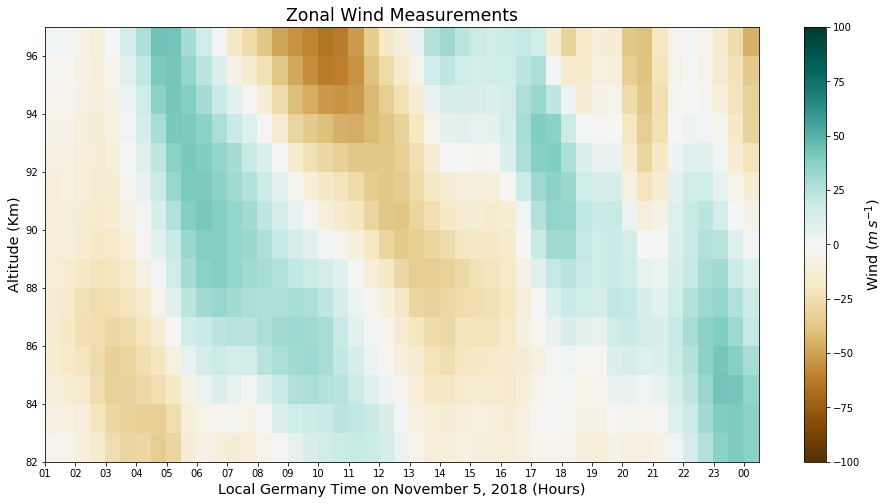

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours (Germany local time) to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

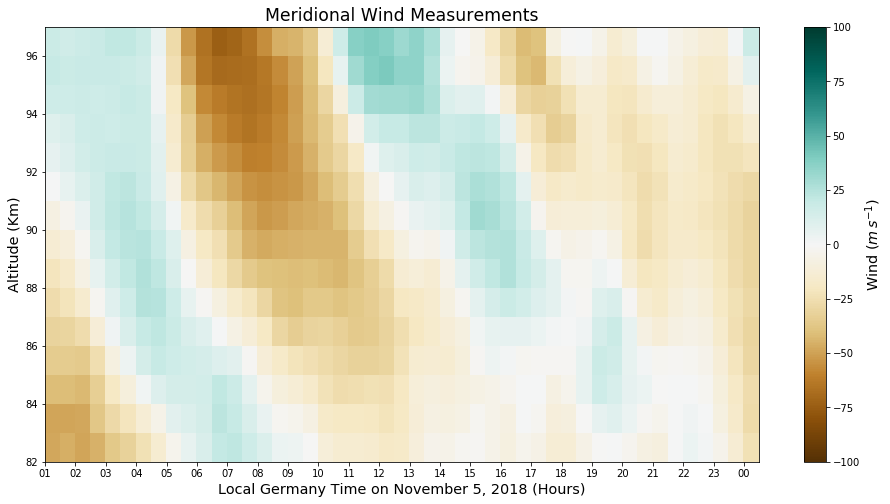

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours (Germany local time) to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

## Begin Creating Smaller Bins

In [25]:
# Smaller time bins

t_step = 1800/2  # seconds (30 minutes)
t_window = 3600/2  # seconds (1 hour)
z_step = 1  # km
z_window = 2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 12*60*60 seconds in 12 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [26]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

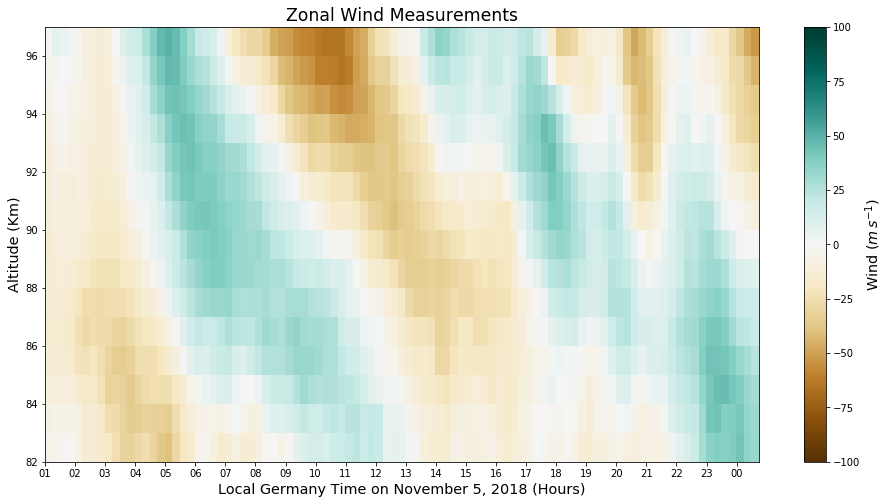

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

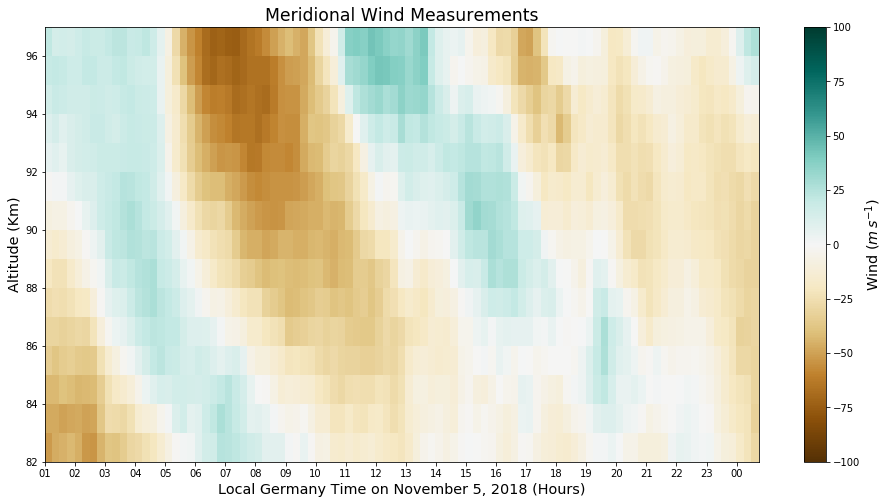

In [28]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [29]:
# Smaller altitude bins

t_step = 1800  # seconds (30 minutes)
t_window = 3600 # seconds (1 hour)
z_step = 1/2  # km
z_window = 2/2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 12*60*60 seconds in 12 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [30]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

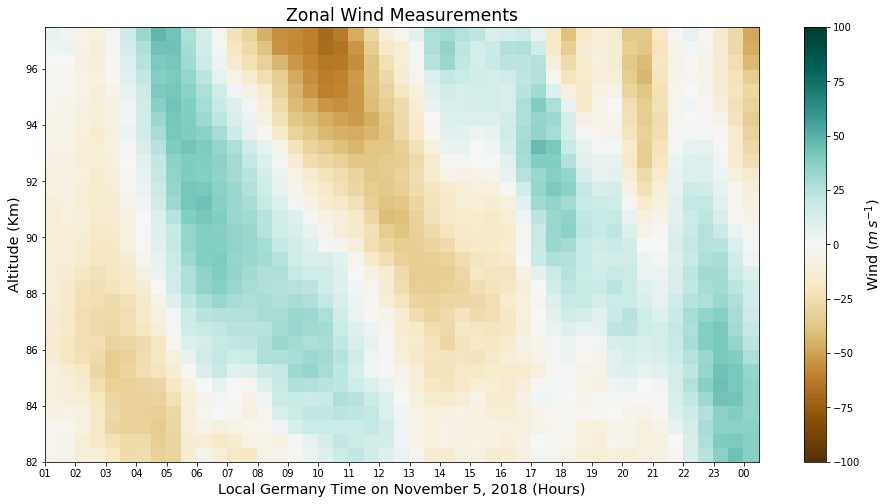

In [31]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

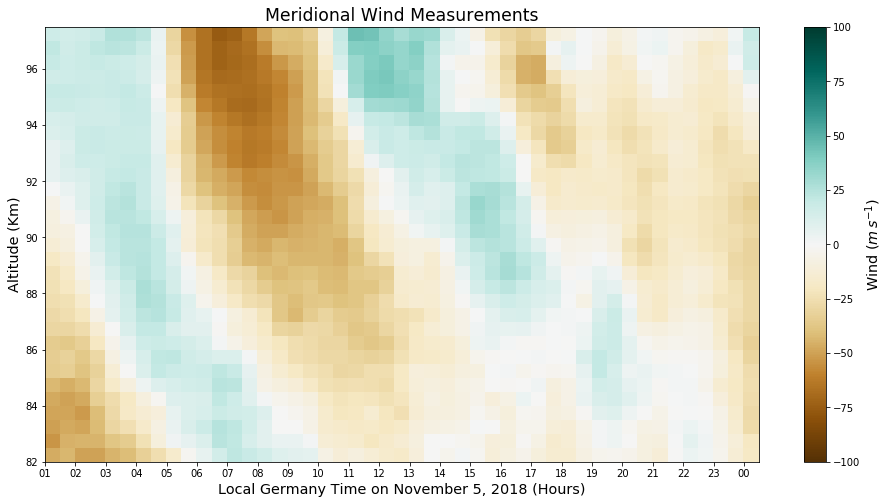

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [33]:
# Smaller time and altitude bins

t_step = 1800/2  # seconds
t_window = 3600/2 # seconds 
z_step = 1/2  # km
z_window = 2/2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [34]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

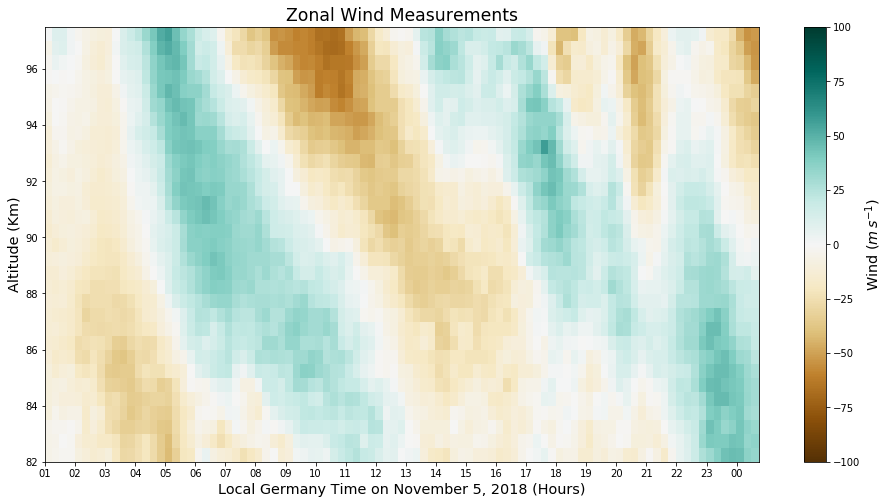

In [35]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

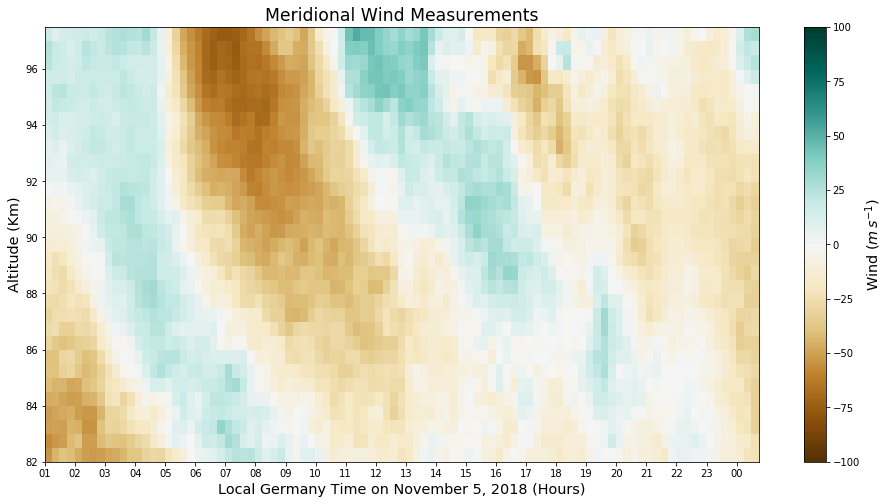

In [36]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [37]:
t_step = 1800 * (9/20) # seconds
t_window = 3600 * (9/20) # seconds
z_step = 1/2 # km
z_window = 2/2 # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [38]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

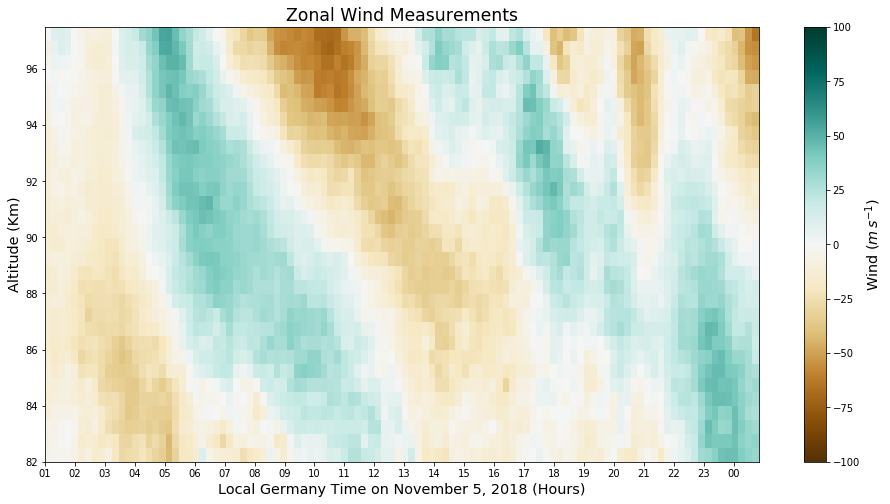

In [39]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

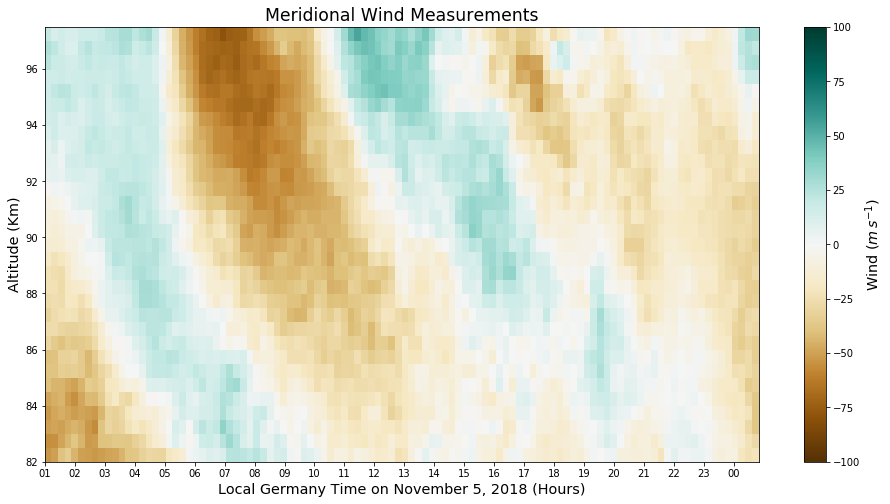

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [41]:
t_step = 1800 * (9/20) # seconds
t_window = 3600 * (9/20) # seconds
z_step = 1 * (9/20) # km
z_window = 2 * (9/20) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [42]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

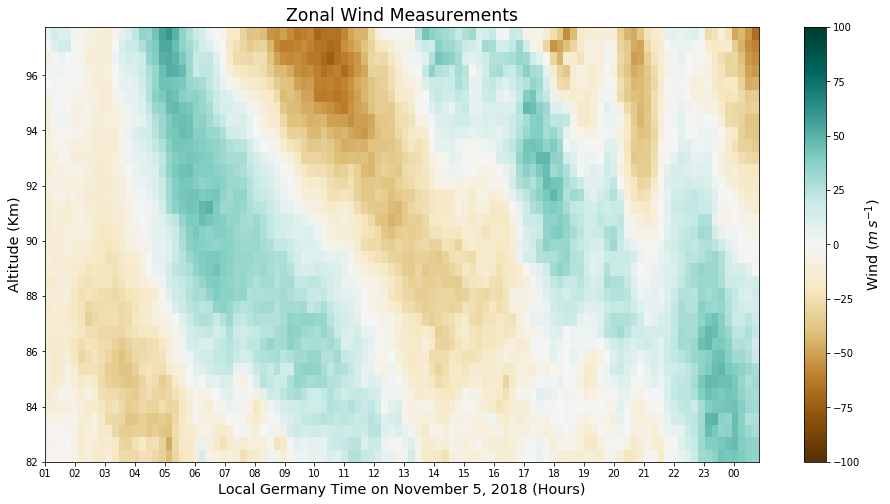

In [43]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

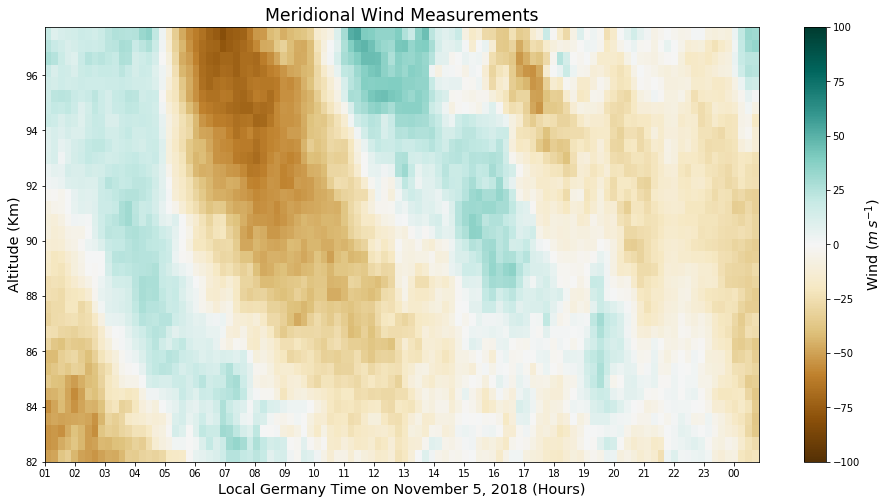

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [45]:
t_step = 1800 * (9/20)  # seconds
t_window = 3600 * (9/20) # seconds 
z_step = 1/2  # km
z_window = 2/2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 12*60*60 seconds in 12 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [46]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

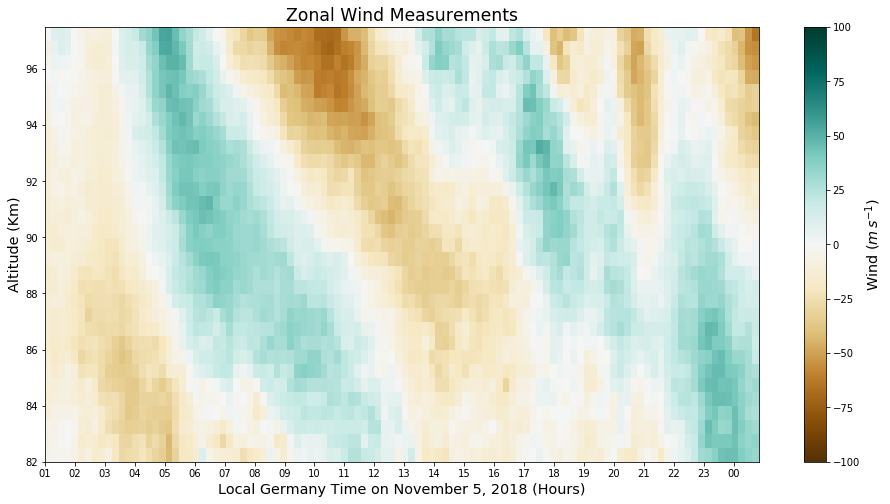

In [47]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

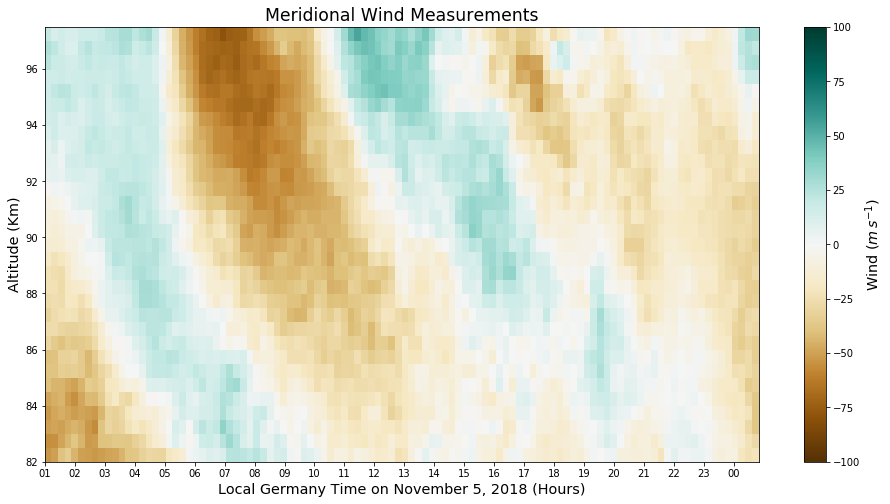

In [48]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [49]:
t_step = 1800 * (17/40) # seconds
t_window = 3600 * (17/40) # seconds
z_step = 1 * (2/5) # km
z_window = 2 * (2/5) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [50]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

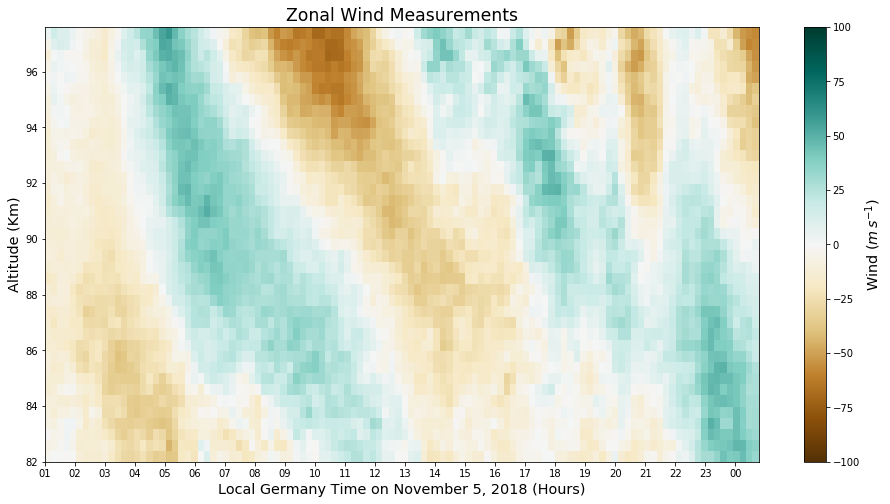

In [51]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

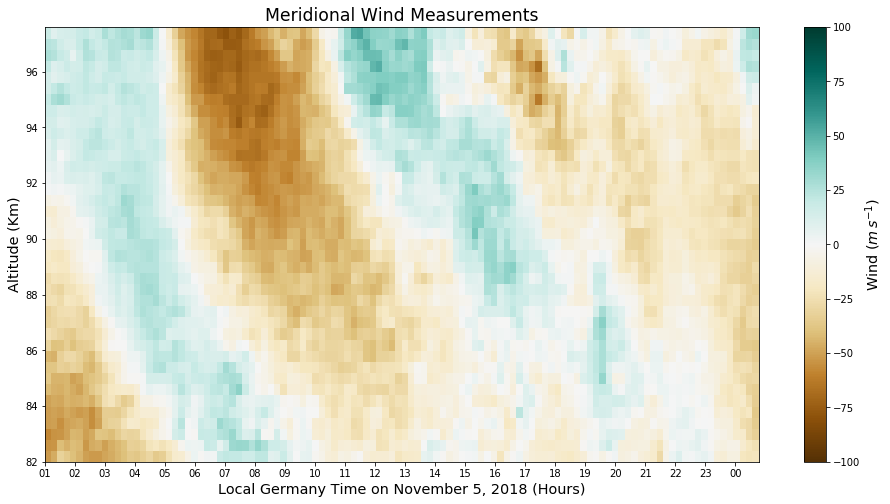

In [52]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [53]:
t_step = 1800 * (19/40) # seconds
t_window = 3600 * (19/40) # seconds
z_step = 1/2 # km
z_window = 2/2 # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [54]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

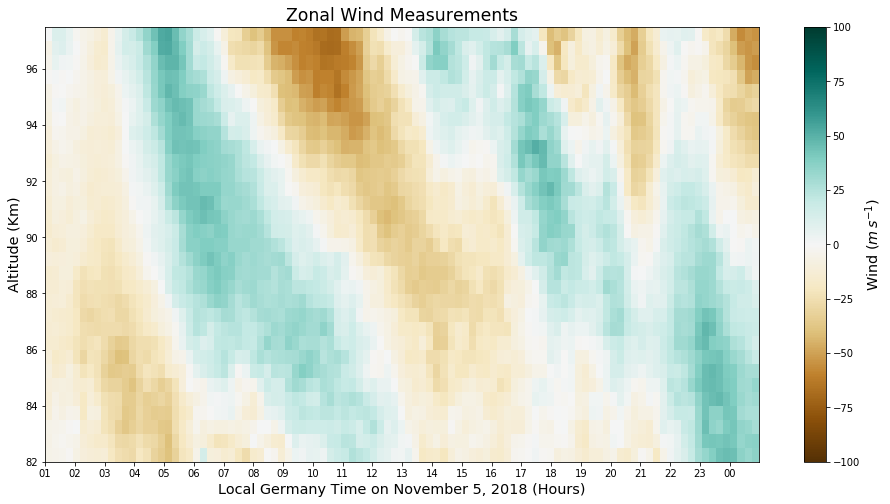

In [55]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

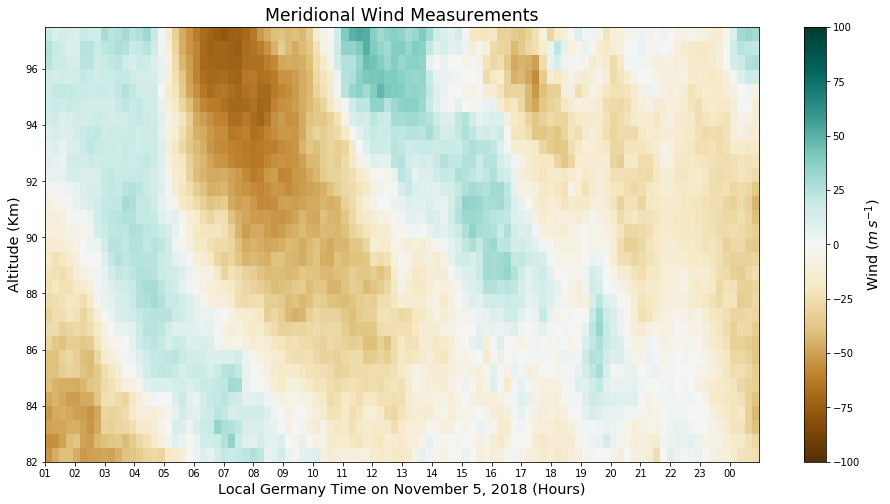

In [56]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [57]:
t_step = 1800 * (2/5) # seconds
t_window = 3600 * (2/5) # seconds
z_step = 1 * (2/5) # km
z_window = 2 * (2/5) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [58]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

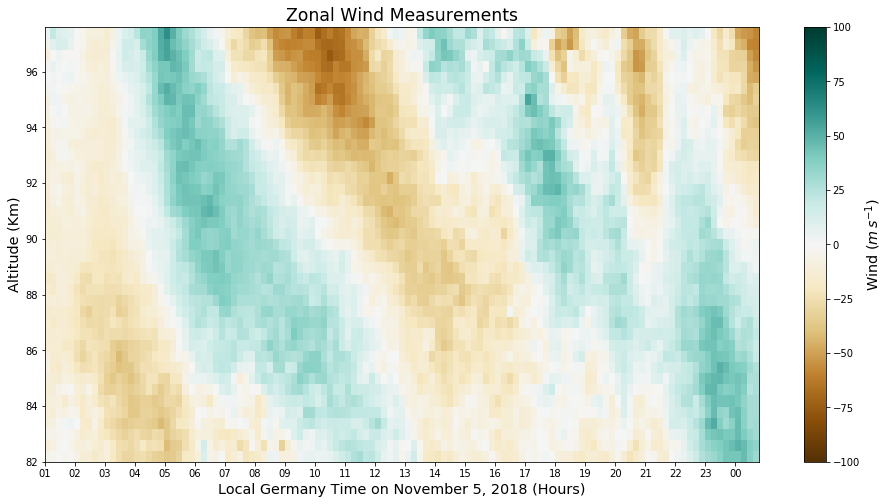

In [59]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

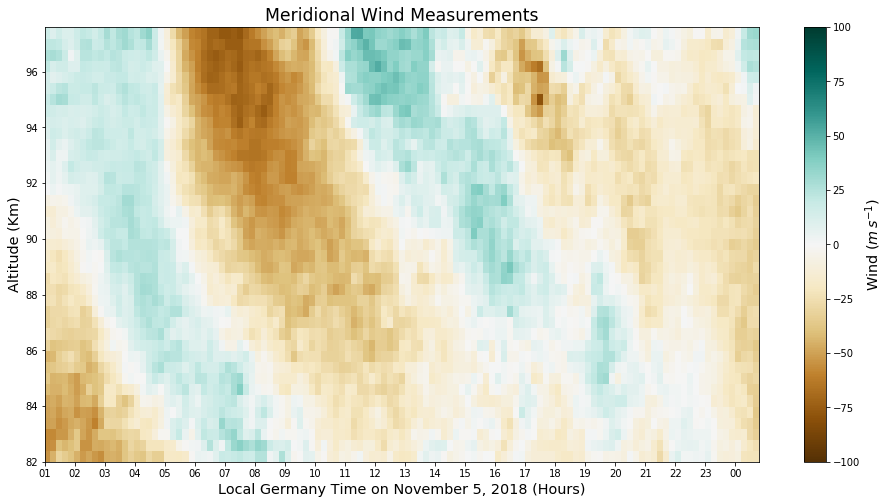

In [60]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [61]:
t_step = 1800 * (7/20) # seconds
t_window = 3600 * (7/20) # seconds
z_step = 1 * (7/20) # km
z_window = 2 * (7/20) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [62]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

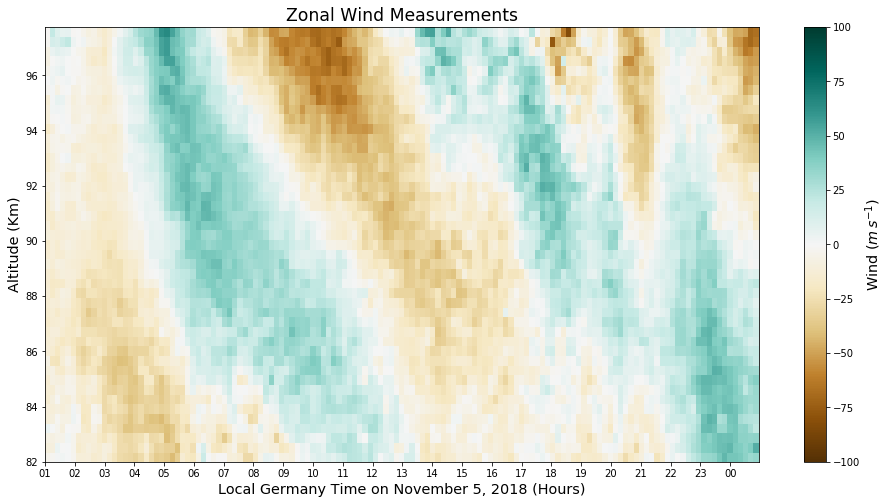

In [63]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

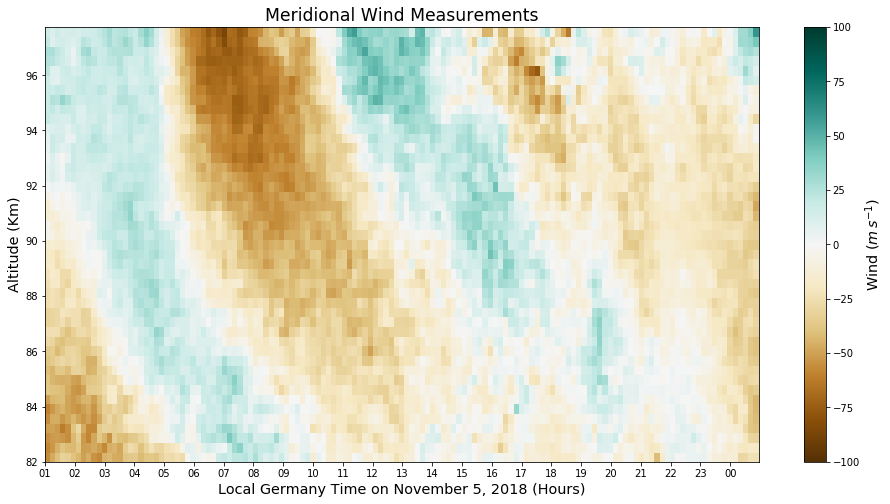

In [64]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [65]:
t_step = 1800 * (3/10) # seconds
t_window = 3600 * (3/10) # seconds
z_step = 1 * (3/10) # km
z_window = 2 * (3/10) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [66]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

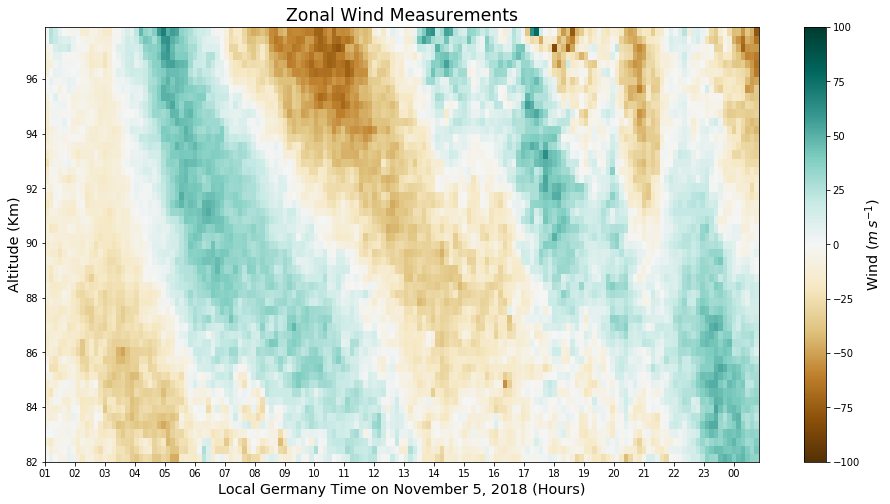

In [67]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

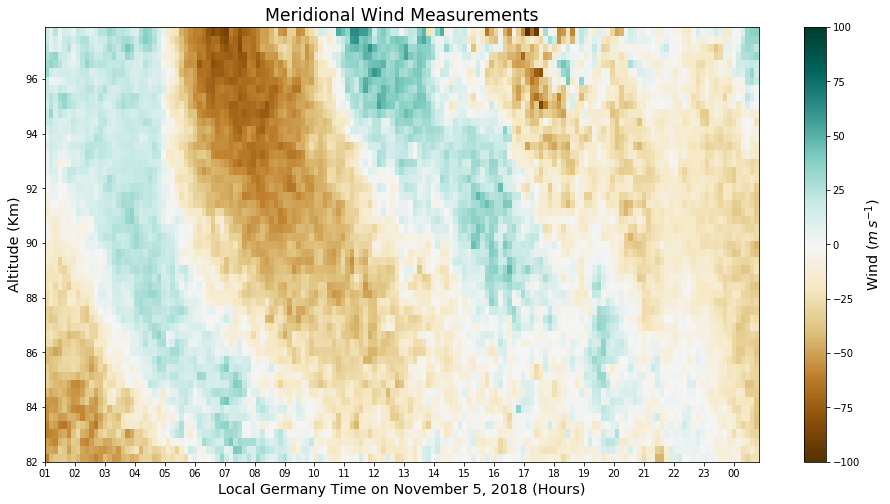

In [68]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [69]:
t_step = 1800 * (3/10) # seconds
t_window = 3600 * (3/10) # seconds
z_step = 1 * (7/20) # km
z_window = 2 * (7/20) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [70]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

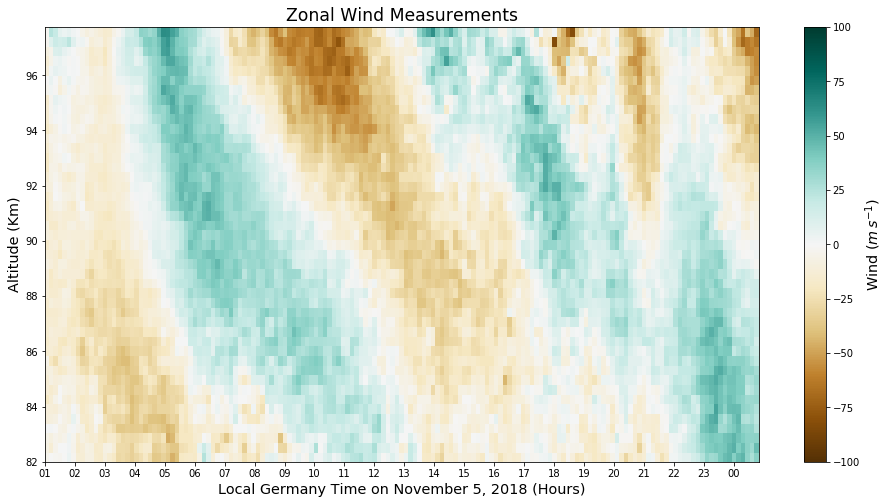

In [71]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

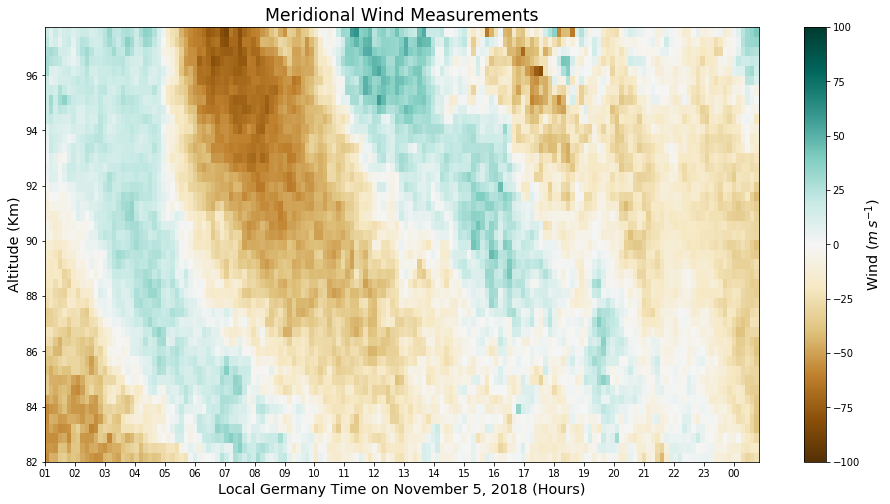

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [73]:
t_step = 1800/4 # seconds
t_window = 3600/4 # seconds
z_step = 1 * (3/10) # km
z_window = 2 * (3/10) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [74]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

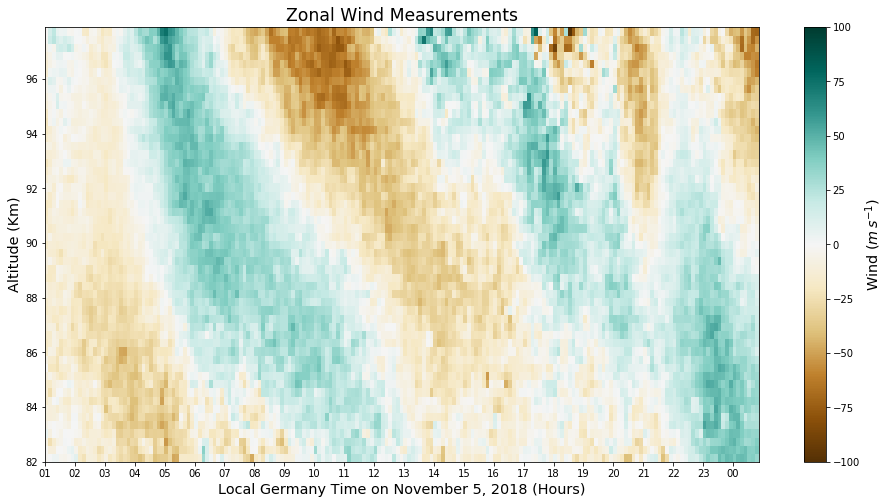

In [75]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

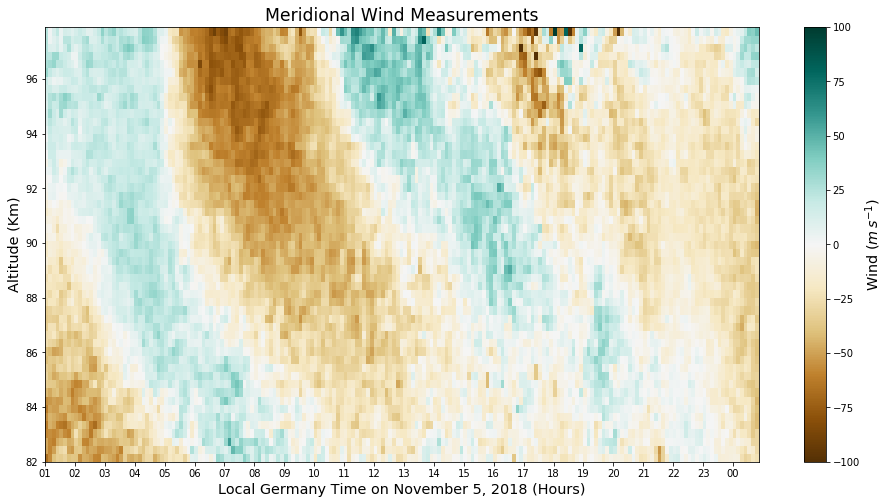

In [76]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [77]:
t_step = 1800 * (3/10) # seconds
t_window = 3600 * (3/10) # seconds
z_step = 1/4 # km
z_window = 2/4 # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [78]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

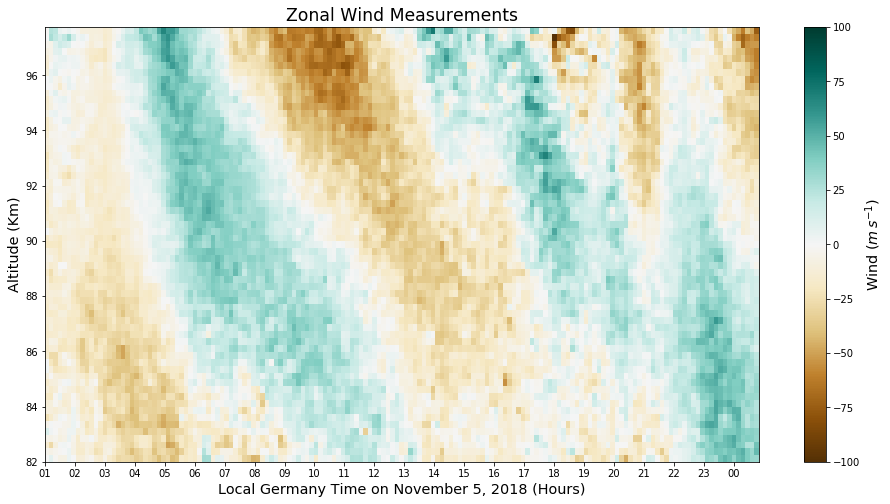

In [79]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

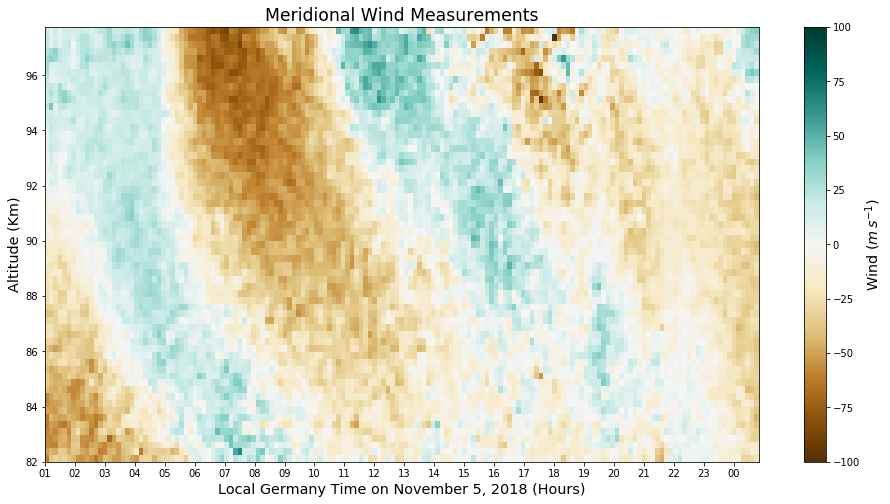

In [80]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [81]:
t_step = 1800/4 # seconds
t_window = 3600/4 # seconds
z_step = 1 * (7/20) # km
z_window = 2 * (7/20) # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [82]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

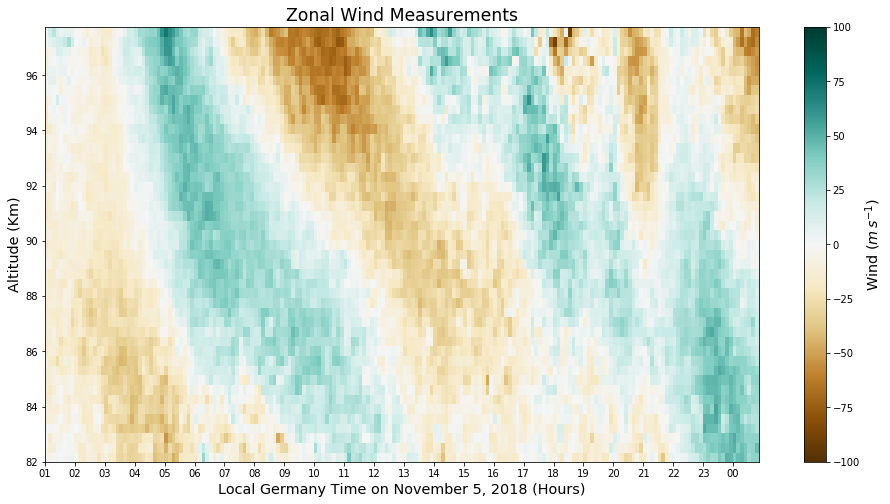

In [83]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

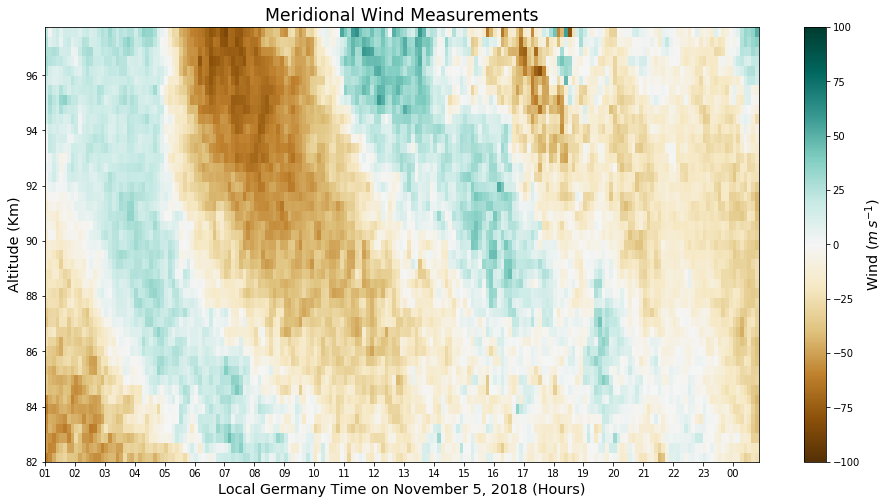

In [84]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [85]:
t_step = 1800/4 # seconds
t_window = 3600/4 # seconds
z_step = 1/4 # km
z_window = 2/4 # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [86]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

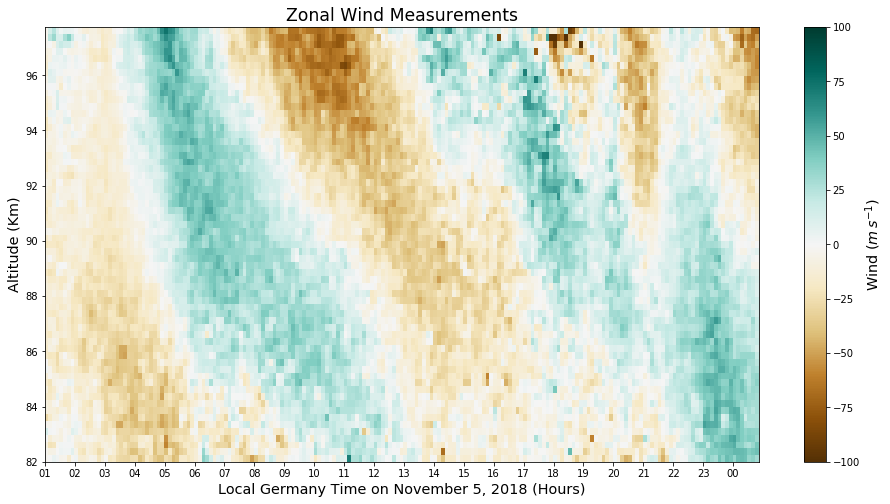

In [87]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

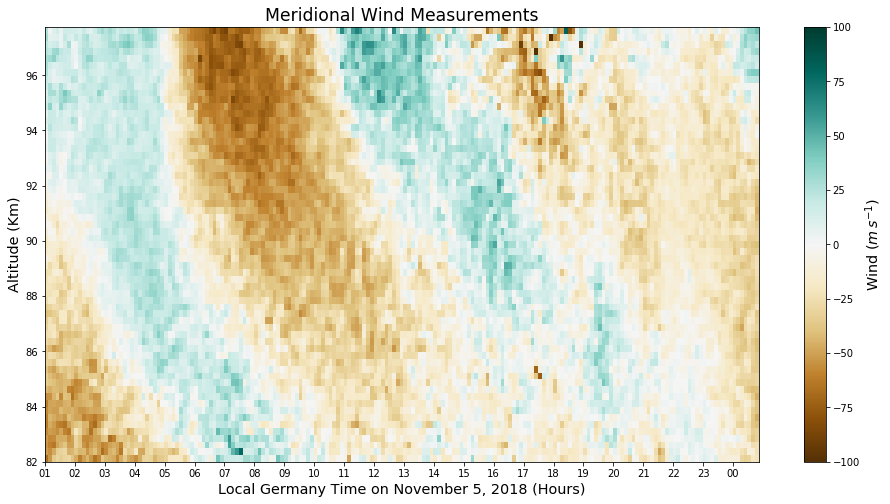

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [89]:
t_step = 1800/5 # seconds
t_window = 3600/5 # seconds
z_step = 1/5 # km
z_window = 2/5 # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [90]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

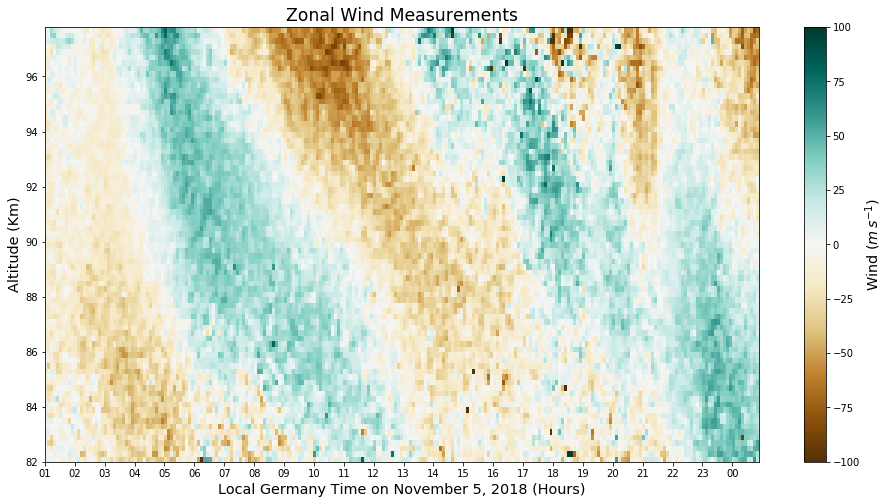

In [91]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

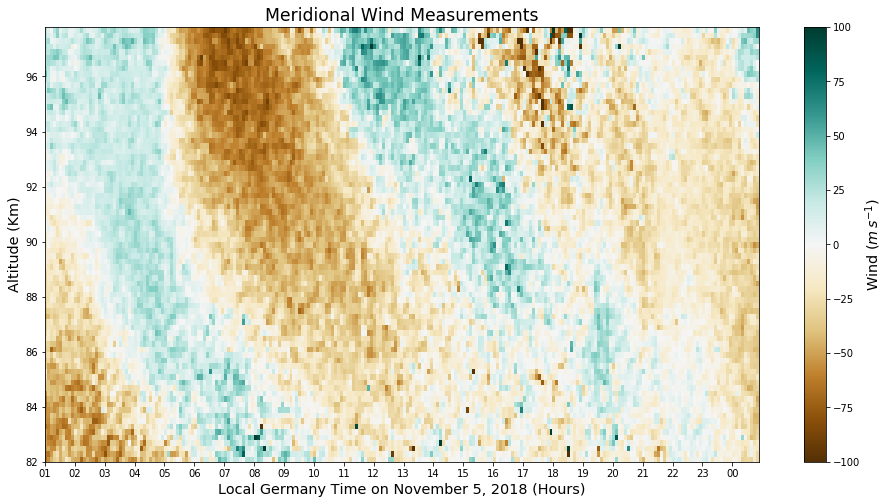

In [92]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()